In [2]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

def int1D(x,f):
    n = np.size(x)
    dx = abs(x[1]-x[0])
    I = 0
    for i in range(1,n-1):
        I+= 0.5*(f[i-1]+f[i+1])*dx
    return I

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'

filename_prefix = directory + '/TKEBudget_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

steps = sorted(reader.steps)
print("Steps: {}".format(steps))

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 1.6
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
Steps: [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 32, 34, 36, 38, 40, 49, 55, 60, 63]


(1.6, 1.0)


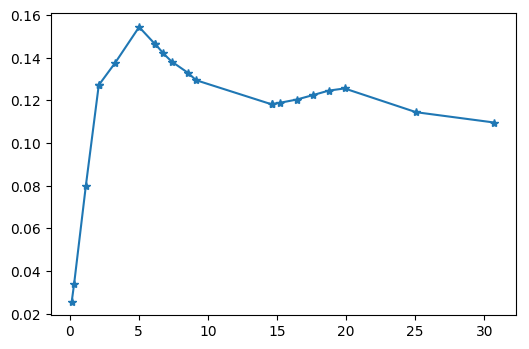

In [3]:
# Integrated profiles

def integrate_term(reader,steps,term):
    
    mat = np.zeros([len(steps),2])
    for i,step in enumerate(steps):
        reader.step = step
        time = reader.time

        # Get dtheta
        idx = np.argmin(abs(tlist-time))
        dtheta = dlist[idx]

        dat = reader.readData(term)
        
        # integrate
        mat[i,0] = time
        mat[i,1] = integrate_y(y,np.squeeze(dat))
    
    # sort by time
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]
        
fig = plt.figure(dpi=100)
matP = integrate_term(reader,steps,'production')
matD = integrate_term(reader,steps,'dissipation')
plt.plot(matP[:,0]/inp.du,matD[:,1],'-*')
print(inp.Mc,inp.rr)

0.2:[0.00489691516259,2.44820386348e-06],
0.4:[0.00381147534899,9.71769974416e-05],
0.8:[0.00310368943132,1.62081496285e-05],
1.2:[0.00244585731812,4.66042798182e-05],
1.6:[0.00219822448592,0.000115078125289],
2.0:[0.00164251095707,2.99173460851e-05],
Done
Done


(0, 200)

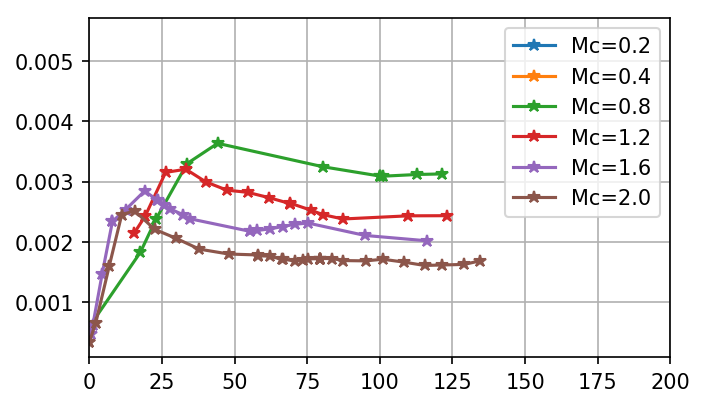

In [36]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/TKEBudget_'
    reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    steps = reader.steps

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')

    mat = integrate_term(reader,steps,'dissipation')
    t = mat[:,0]
    f = mat[:,1]/inp.du**3
    plt.plot(t,f,'-*',label='Mc={}'.format(inp.Mc))
    
    idx = max(4,np.size(t)-5)
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:]),np.std(f[idx:])))
    
print('Done')
print('Done')
plt.grid(True)
plt.legend()
plt.xlim([0,200])
# ax[0].set_xlim([-20,1000])
# ax[0].set_ylim([-5e-4,1e-3])
# plt.savefig('/home/kmatsuno/ShearLayer_img/vs_t/'+'diss_s%s'%s,dpi=200,bbox_inches='tight')

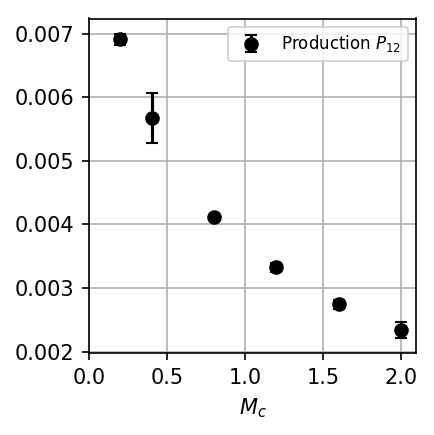

In [32]:
# Rij vs. Mc
prod = {
0.2:[0.0069131294931,8.78328315999e-05],
0.4:[0.00567523508046,0.000395412567946],
0.8:[0.0041233690618,2.35441708582e-05],
1.2:[0.00332694700816,7.16790844552e-05],
1.6:[0.0027435232399,6.72810544718e-05],
2.0:[0.00233437380966,0.000124826518299],
}
diss = {
0.2:[0.00503799851949,0.000244372740003],
0.4:[0.00387999090505,0.000125237143318],
0.8:[0.00310368943132,1.62081496285e-05],
1.2:[0.0025281885164,0.000102324091441],
1.6:[0.00219822448592,0.000115078125289],
2.0:[0.00164251095707,2.99173460851e-05],
}
prod_diss = {}
for key in prod.keys():
    prod_diss[key] = [diss[key][0]/prod[key][0], (diss[key][1]**2+prod[key][1]**2)**0.5]
baro = {
0.2:[-1.68629195456e-06,1.63153127333e-07],
0.4:[-4.10547243914e-06,1.28985803635e-06],
0.8:[-8.41724725715e-06,6.15540691286e-07],
1.2:[-1.03059130074e-05,1.129025805e-06],
1.6:[-1.1165350634e-05,1.15333394441e-06],
2.0:[-9.23954841657e-06,9.01671404496e-07],
}
prod_vreman = {
0.2:[-0.20869268292682946,0],
0.6:[-0.14980487804878045,0],
0.8:[-0.10879999999999995,0],
1.2:[-0.061492682926829245,0]
}
diss_vreman = {
0.2:[ -0.04732435525899231,0],
0.6:[-0.04371380561576099,0],
0.8:[-0.045183742054891174,0],
1.2:[ -0.04087913693592765,0]
}
def plotter(dat,label,fmt):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],fmt=fmt,label=label,capsize=3)

fig = plt.figure(figsize=(3,3),dpi=150)
plotter(prod,r'Production $P_{12}$','ko')
# plotter(diss,r'Dissipation $\epsilon$','kx')
# plotter(baro,r'Baropycnal','k^')
# plotter(prod_diss,r'$\epsilon / P_{12}$','ks')
# plotter(prod_vreman,r'$P$','rx')

plt.grid(True)
plt.xlabel(r'$M_c$')
# plt.ylabel(r'$R_{ij}$')
plt.legend(fontsize=8)
plt.xlim([0,2.1])
# plt.ylim([0.6,0.9])
plt.tight_layout()
plt.savefig('/home/kmatsuno/ShearLayer_img/prod.png',dpi=200, bbox_inches='tight')

/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/
/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/724x1024x362/
/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/512x724x256/
Done
Done


Text(0.5,0,'$t/\\Delta U$')

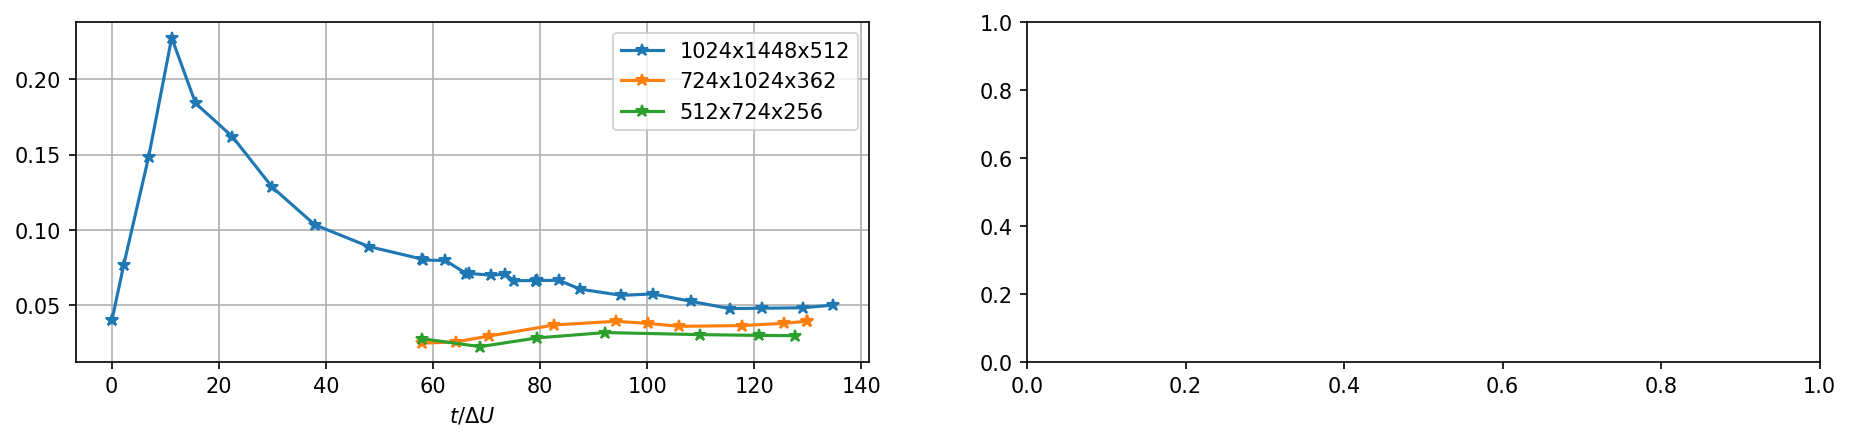

In [95]:
s = '1'
Mc = '20'
gridlist = ['1024x1448x512','724x1024x362','512x724x256']
    
fig,ax = plt.subplots(1,2,figsize=(15,3),dpi=150)

for gridres in gridlist:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/%s/'%(Mc,s,gridres)
    filename_prefix = directory + '/TKEBudget_'
    reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    steps = reader.steps
    print(directory)

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')

#     matP = integrate_term(reader,steps,'production')
#     matD = integrate_term(reader,steps,'dissipation')
#     ax[0].plot(matP[:,0],matP[:,1]/matD[:,1],'-*',label='{}'.format(gridres))    
    mat = integrate_term(reader,steps,'dissipation')
    ax[0].plot(mat[:,0],mat[:,1],'-*',label='{}'.format(gridres))
    
print('Done')
print('Done')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlabel(r'$t/\Delta U$')
